In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from Bayesian2 import BayesianLinearRegression
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
dtype_dict = {
    'Date': 'str',
    'FarmName_Pseudo': 'str',
    'SE_Number': 'str',
    'Age': 'Int64',
    'BreedName': 'str',
    'DailyYield': 'float',
    'PreviousDailyYield': 'float',
    'DailyYieldChange': 'float',
    'DaysInMilk': 'float',
    'YearSeason': 'str',
    'LactationNumber': 'float',
    'ExpectedYield': 'float',
    'NormalizedDailyYield': 'float',
    'NormalizedDailyYieldChange': 'float',
    'HeatStress': 'Int64',
    'Temp15Threshold': 'Int64',
    'HW': 'Int64',
    'cum_HW': 'Int64',
    'MeanTemperature': 'float',
    'MeanTHI_adj': 'float',
    'FarmHeatStressMilkProduction': 'float'
}

milk_data = pd.read_csv('../Data/MergedData/BLRMilkFarmYieldData.csv', dtype=dtype_dict)
milk_data['Date'] = pd.to_datetime(milk_data['Date'], format='%Y-%m-%d')
# Update YearSeason to 'YYYY-S' format
milk_data['YearSeason'] = milk_data['Date'].dt.year.astype(str) + '-' + milk_data['Date'].dt.month.sub(1).floordiv(3).add(1).astype(str)

# Calculate the LactationStartDate
milk_data['LactationStartDate'] = milk_data.groupby(['SE_Number', 'LactationNumber'])['Date'].transform('min')

# Get the Age at the LactationStartDate
lactation_start_age = milk_data[milk_data['Date'] == milk_data['LactationStartDate']].set_index(['SE_Number', 'LactationNumber'])['Age']

# Merge the start age back into the original DataFrame
milk_data = milk_data.merge(lactation_start_age.rename('AgeAtLactationStart'), on=['SE_Number', 'LactationNumber'])

# Encode categorical data
encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_breeds = pd.DataFrame(encoder.fit_transform(milk_data[['BreedName']]), columns=encoder.get_feature_names_out(['BreedName']))
milk_data = pd.concat([milk_data, encoded_breeds], axis=1)
milk_data.head(-5)

,Date,FarmName_Pseudo,SE_Number,Age,BreedName,LactationNumber,DaysInMilk,YearSeason,DailyYield,PreviousDailyYield,...,FarmHeatStressMilkProduction,LactationStartDate,AgeAtLactationStart,BreedName_02 SLB,BreedName_04 SJB,BreedName_06 RB,BreedName_27 Montbéliard,BreedName_41 Fjällko,BreedName_99 Korsning/obestämbar ras,BreedName_Unknown Breed
0,2022-05-28,a624fb9a,SE-064c0cec-1189,3242,02 SLB,8.0,3.0,2022-2,15.22,0.0000,...,NaN,2022-05-28,3242,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2022-05-29,a624fb9a,SE-064c0cec-1189,3243,02 SLB,8.0,4.0,2022-2,18.96,15.2200,...,NaN,2022-05-28,3242,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2022-05-30,a624fb9a,SE-064c0cec-1189,3244,02 SLB,8.0,5.0,2022-2,22.64,17.0900,...,NaN,2022-05-28,3242,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2022-05-31,a624fb9a,SE-064c0cec-1189,3245,02 SLB,8.0,6.0,2022-2,26.49,18.9400,...,NaN,2022-05-28,3242,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2022-06-01,a624fb9a,SE-064c0cec-1189,3246,02 SLB,8.0,7.0,2022-2,33.61,20.8275,...,NaN,2022-05-28,3242,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
465310,2023-06-03,f454e660,SE-fcdf259d-0044-0,4150,41 Fjällko,10.0,347.0,2023-2,12.67,14.6520,...,NaN,2022-06-25,3807,0.0,0.0,0.0,0.0,1.0,0.0,0.0
465311,2023-06-04,f454e660,SE-fcdf259d-0044-0,4151,41 Fjällko,10.0,348.0,2023-2,22.31,14.0300,...,NaN,2022-06-25,3807,0.0,0.0,0.0,0.0,1.0,0.0,0.0
465312,2023-06-05,f454e660,SE-fcdf259d-0044-0,4152,41 Fjällko,10.0,349.0,2023-2,12.84,14.9840,...,NaN,2022-06-25,3807,0.0,0.0,0.0,0.0,1.0,0.0,0.0
465313,2023-06-06,f454e660,SE-fcdf259d-0044-0,4153,41 Fjällko,10.0,350.0,2023-2,9.47,14.8920,...,NaN,2022-06-25,3807,0.0,0.0,0.0,0.0,1.0,0.0,0.0


## Farm a624fb9a

In [3]:
# Select the farm
farm = 'a624fb9a'
daily_farm_data = milk_data[milk_data['FarmName_Pseudo'] == farm].copy()

# Ensure the feature 'MeanTemperature' is float type
daily_farm_data['MeanTemperature'] = daily_farm_data['MeanTemperature'].astype(float)

# Scale features
scaler = StandardScaler()
daily_farm_data[['MeanTemperature', 'Age']] = scaler.fit_transform(daily_farm_data[['MeanTemperature', 'Age']])

# Function to fit model and calculate yield change
def fit_model_and_calculate_yield_change(data, feature, additional_features):
    yield_changes = []
    grouped_data = data.groupby(['YearSeason', 'SE_Number'])
    
    for (year_season, cow), group in grouped_data:
        cow_data = group

        # Prepare features
        X = cow_data[[feature] + additional_features]
        y = cow_data['NormalizedDailyYield']

        # Calculate prior mean and variance
        cow_mean = y.mean()
        cow_variance = y.var() if y.var() > 1e-6 else 1e-6
        beta = 1 / cow_variance
        prior_mean_value = X.mean(axis=0)

        # Define priors
        prior_mean = np.append([cow_mean], prior_mean_value.values).reshape(-1, 1)
        prior_cov = np.eye(len(prior_mean)) * 0.01

        # Fit model
        model = BayesianLinearRegression(
            dataframe=cow_data,
            subject_name=cow,
            selected_features=[feature] + additional_features,
            target='NormalizedDailyYield',
            subject_type='cow',
            prior_mean=prior_mean,
            prior_cov=prior_cov,
            beta=beta
        )
        result = model.fit_model()

        # Store results
        yield_changes.append({
            'YearSeason': year_season,
            'SE_Number': cow,
            'Yield HeatStress': result['Off-set']['mu']
        })

    return pd.DataFrame(yield_changes)

# Define features
selected_feature = 'MeanTemperature'
additional_features = list(encoded_breeds.columns) + ['Age']

# Separate data for HeatStress=1 and HeatStress=0 conditions
data_heatstress_1 = daily_farm_data[daily_farm_data['HeatStress'] == 1]
data_heatstress_0 = daily_farm_data[daily_farm_data['HeatStress'] == 0]

# Fit models and calculate yield changes
yield_changes_heatstress_1 = fit_model_and_calculate_yield_change(data_heatstress_1, selected_feature, additional_features)
yield_changes_heatstress_0 = fit_model_and_calculate_yield_change(data_heatstress_0, selected_feature, additional_features)

# Merge results with breed data and calculate deviations
results_df = yield_changes_heatstress_1.merge(
    yield_changes_heatstress_0, on=['YearSeason', 'SE_Number'], suffixes=('=1', '=0')
)

# Merge age and breed data back to results_df using the AgeAtLactationStart column
# Ensure unique combinations of SE_Number and YearSeason in the daily_farm_data for merging
unique_age_breed_data = daily_farm_data[['SE_Number', 'YearSeason', 'AgeAtLactationStart', 'BreedName']].drop_duplicates(subset=['SE_Number', 'YearSeason'])

results_df = results_df.merge(
    unique_age_breed_data, on=['SE_Number', 'YearSeason'], how='left'
)

# Calculate the correct deviation from baseline
# baseline_yield_change = daily_farm_data['NormalizedDailyYield'].mean() + data_heatstress_1['FarmHeatStressMilkProduction'].mean()
baseline_yield_change = daily_farm_data['NormalizedDailyYield'].mean()
results_df['Deviation from Baseline HeatStress=1'] = results_df['Yield HeatStress=1'] - baseline_yield_change  # Corrected calculation

# Reorder columns to make SE_Number the first column
results_df = results_df[['SE_Number', 'YearSeason', 'AgeAtLactationStart', 'BreedName', 'Yield HeatStress=1', 'Yield HeatStress=0', 'Deviation from Baseline HeatStress=1']]
results_df

,SE_Number,YearSeason,AgeAtLactationStart,BreedName,Yield HeatStress=1,Yield HeatStress=0,Deviation from Baseline HeatStress=1
0,SE-064c0cec-1189,2022-2,3242,02 SLB,0.985332,1.039193,-0.015362
1,SE-30dc5787-1389,2022-2,2531,01 SRB,0.953841,0.982344,-0.046854
2,SE-30dc5787-1396,2022-2,2479,02 SLB,0.993712,1.035086,-0.006982
3,SE-30dc5787-1402,2022-2,2462,02 SLB,1.003869,0.967323,0.003174
4,SE-a624fb9a-1039,2022-2,4126,02 SLB,0.989231,0.997459,-0.011463
...,...,...,...,...,...,...,...
391,SE-a624fb9a-1491,2023-3,714,01 SRB,0.945569,1.129010,-0.055125
392,SE-a624fb9a-1493,2023-3,766,01 SRB,0.946609,1.020200,-0.054085
393,SE-a624fb9a-1496,2023-3,743,02 SLB,0.913976,1.102443,-0.086718
394,SE-a624fb9a-1503,2023-3,736,01 SRB,1.022559,0.979576,0.021864


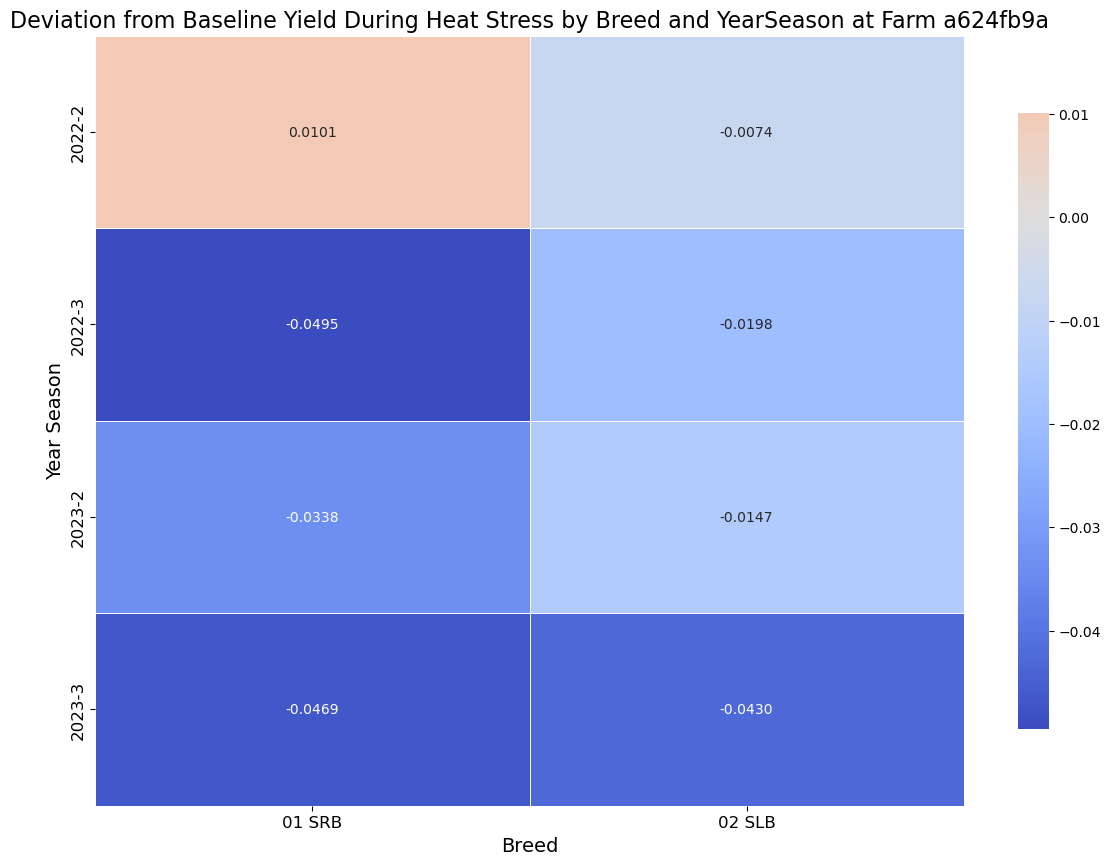

In [4]:
# Pivot data for heatmap
heatmap_data = results_df.pivot_table(index='YearSeason', columns='BreedName', values='Deviation from Baseline HeatStress=1')

plt.figure(figsize=(14, 10))
sns.heatmap(heatmap_data, annot=True, cmap="coolwarm", center=0, fmt=".4f", linewidths=.5, cbar_kws={"shrink": .8})
plt.title(f'Deviation from Baseline Yield During Heat Stress by Breed and YearSeason at Farm {farm}', fontsize=16)
plt.xlabel('Breed', fontsize=14)
plt.ylabel('Year Season', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

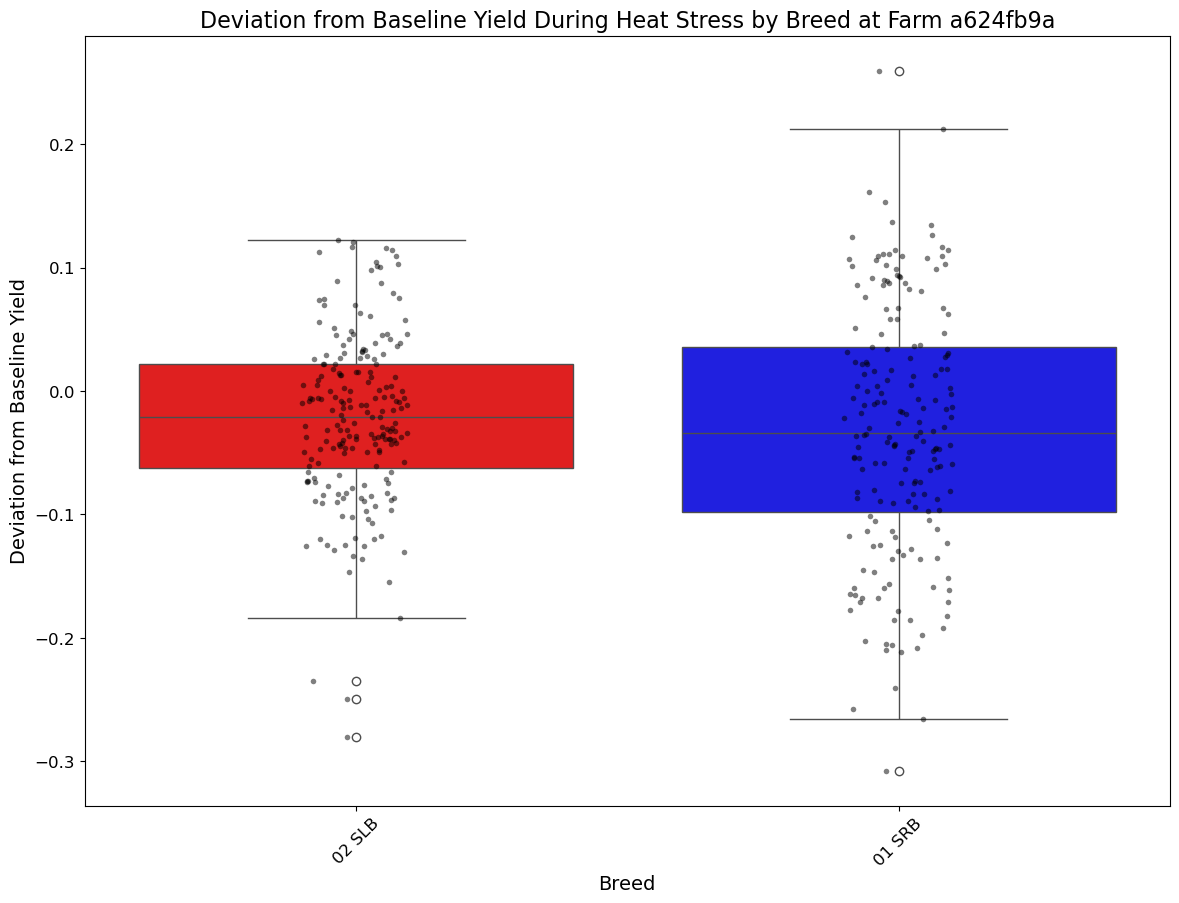

In [5]:
# Define a custom color palette with bright colors
custom_palette = ['#FF0000', '#0000FF']  # Bright red, Bright blue

plt.figure(figsize=(14, 10))
sns.boxplot(x='BreedName', y='Deviation from Baseline HeatStress=1', data=results_df, hue='BreedName', palette=custom_palette, dodge=False)
sns.stripplot(x='BreedName', y='Deviation from Baseline HeatStress=1', data=results_df, color='black', size=4, jitter=True, alpha=0.5, dodge=False)
plt.title(f'Deviation from Baseline Yield During Heat Stress by Breed at Farm {farm}', fontsize=16)
plt.xlabel('Breed', fontsize=14)
plt.ylabel('Deviation from Baseline Yield', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend([],[], frameon=False)  # Remove the legend
plt.show()

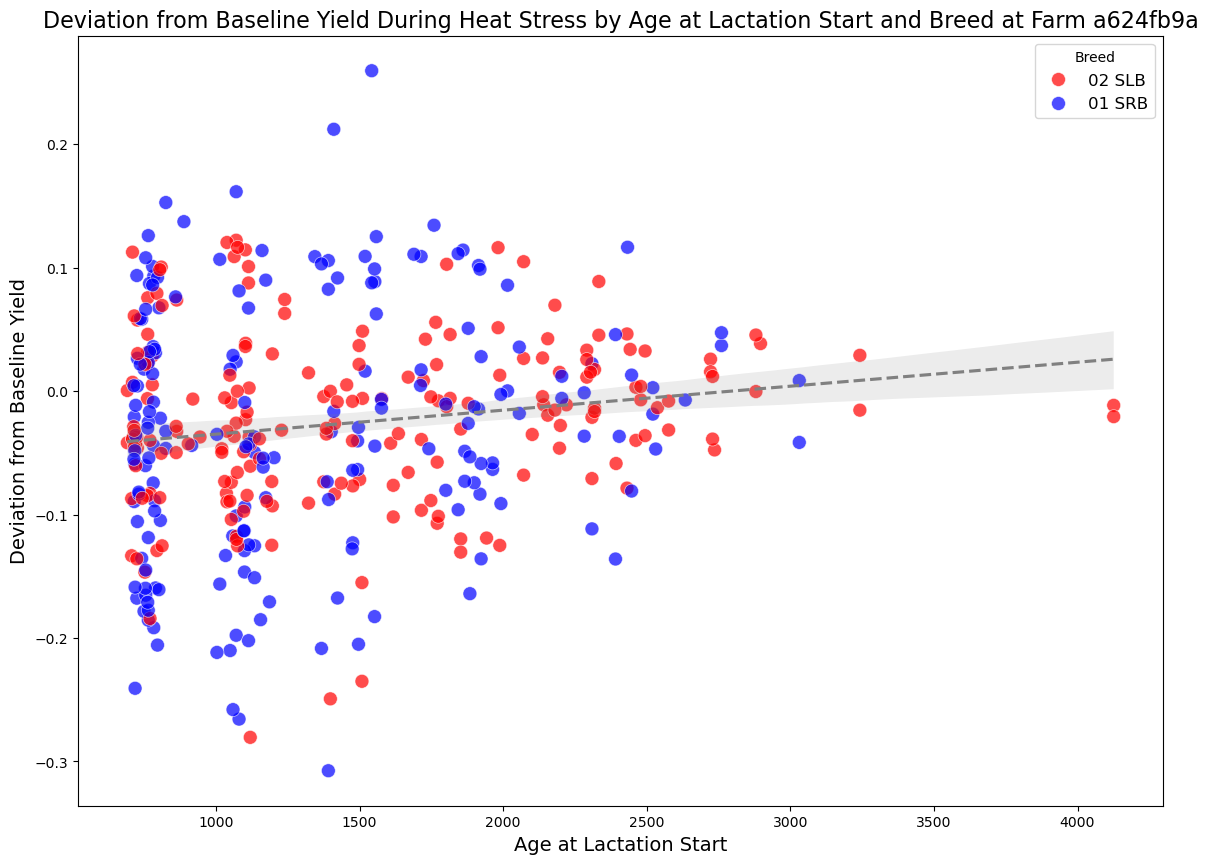

In [6]:
plt.figure(figsize=(14, 10))
sns.scatterplot(x='AgeAtLactationStart', y='Deviation from Baseline HeatStress=1', hue='BreedName', data=results_df, palette=custom_palette, s=100, alpha=0.7, edgecolor='w', linewidth=0.5)
sns.regplot(x='AgeAtLactationStart', y='Deviation from Baseline HeatStress=1', data=results_df, scatter=False, color='gray', line_kws={"linestyle":"--"})
plt.title(f'Deviation from Baseline Yield During Heat Stress by Age at Lactation Start and Breed at Farm {farm}', fontsize=16)
plt.xlabel('Age at Lactation Start', fontsize=14)
plt.ylabel('Deviation from Baseline Yield', fontsize=14)
plt.legend(title='Breed', fontsize=12)
plt.show()

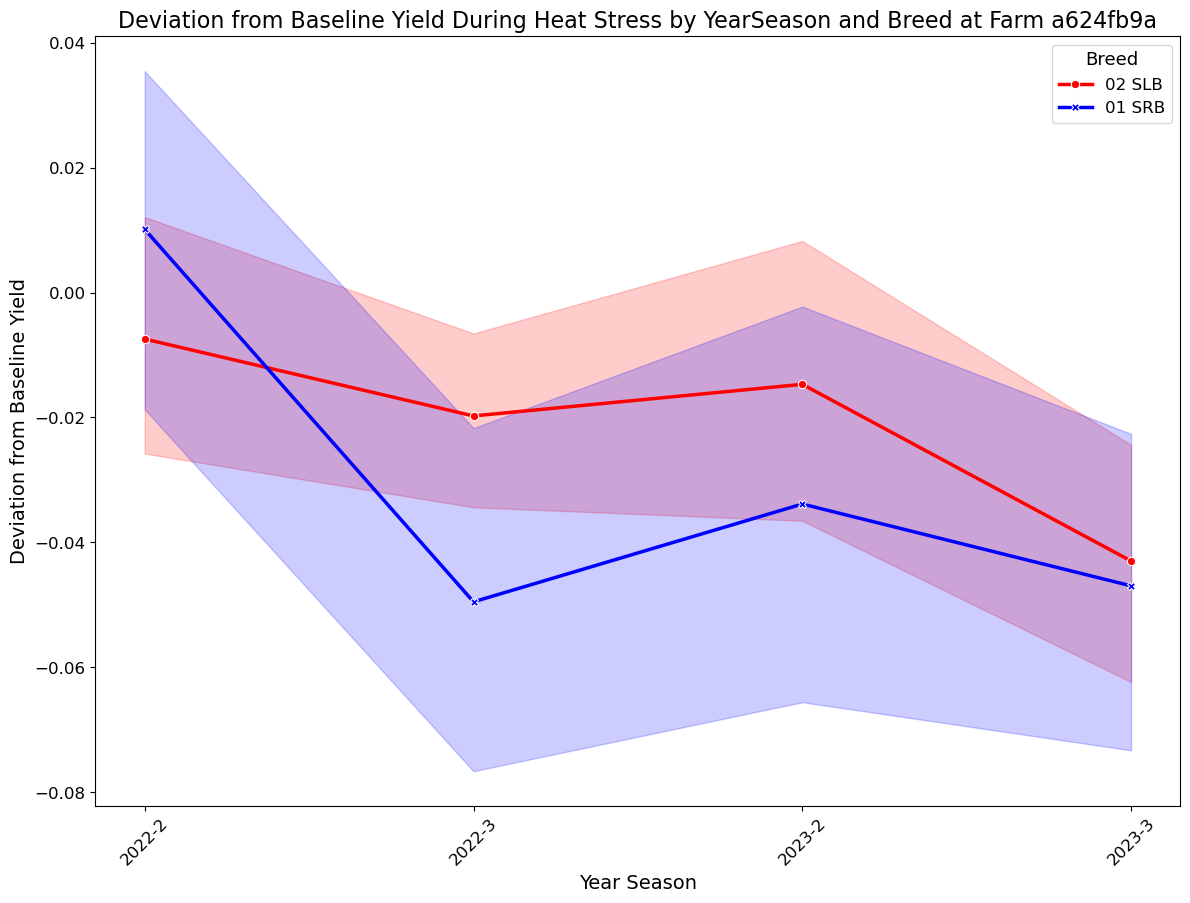

In [7]:
plt.figure(figsize=(14, 10))
sns.lineplot(x='YearSeason', y='Deviation from Baseline HeatStress=1', hue='BreedName', data=results_df, marker='o', palette=custom_palette, linewidth=2.5, style='BreedName', markers=True, dashes=False)
plt.title(f'Deviation from Baseline Yield During Heat Stress by YearSeason and Breed at Farm {farm}', fontsize=16)
plt.xlabel('Year Season', fontsize=14)
plt.ylabel('Deviation from Baseline Yield', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Breed', fontsize=12, title_fontsize='13')
plt.show()

## Farm 5c06d92d

In [8]:
# Select the farm
farm = '5c06d92d'
daily_farm_data = milk_data[milk_data['FarmName_Pseudo'] == farm].copy()

# Ensure the feature 'MeanTemperature' is float type
daily_farm_data['MeanTemperature'] = daily_farm_data['MeanTemperature'].astype(float)

# Scale features
scaler = StandardScaler()
daily_farm_data[['MeanTemperature', 'Age']] = scaler.fit_transform(daily_farm_data[['MeanTemperature', 'Age']])

# Function to fit model and calculate yield change
def fit_model_and_calculate_yield_change(data, feature, additional_features):
    yield_changes = []
    grouped_data = data.groupby(['YearSeason', 'SE_Number'])
    
    for (year_season, cow), group in grouped_data:
        cow_data = group

        # Prepare features
        X = cow_data[[feature] + additional_features]
        y = cow_data['NormalizedDailyYield']

        # Calculate prior mean and variance
        cow_mean = y.mean()
        cow_variance = y.var() if y.var() > 1e-6 else 1e-6
        beta = 1 / cow_variance
        prior_mean_value = X.mean(axis=0)

        # Define priors
        prior_mean = np.append([cow_mean], prior_mean_value.values).reshape(-1, 1)
        prior_cov = np.eye(len(prior_mean)) * 0.01

        # Fit model
        model = BayesianLinearRegression(
            dataframe=cow_data,
            subject_name=cow,
            selected_features=[feature] + additional_features,
            target='NormalizedDailyYield',
            subject_type='cow',
            prior_mean=prior_mean,
            prior_cov=prior_cov,
            beta=beta
        )
        result = model.fit_model()

        # Store results
        yield_changes.append({
            'YearSeason': year_season,
            'SE_Number': cow,
            'Yield HeatStress': result['Off-set']['mu']
        })

    return pd.DataFrame(yield_changes)

# Define features
selected_feature = 'MeanTemperature'
additional_features = list(encoded_breeds.columns) + ['Age']

# Separate data for HeatStress=1 and HeatStress=0 conditions
data_heatstress_1 = daily_farm_data[daily_farm_data['HeatStress'] == 1]
data_heatstress_0 = daily_farm_data[daily_farm_data['HeatStress'] == 0]

# Fit models and calculate yield changes
yield_changes_heatstress_1 = fit_model_and_calculate_yield_change(data_heatstress_1, selected_feature, additional_features)
yield_changes_heatstress_0 = fit_model_and_calculate_yield_change(data_heatstress_0, selected_feature, additional_features)

# Merge results with breed data and calculate deviations
results_df = yield_changes_heatstress_1.merge(
    yield_changes_heatstress_0, on=['YearSeason', 'SE_Number'], suffixes=('=1', '=0')
)

# Merge age and breed data back to results_df using the AgeAtLactationStart column
# Ensure unique combinations of SE_Number and YearSeason in the daily_farm_data for merging
unique_age_breed_data = daily_farm_data[['SE_Number', 'YearSeason', 'AgeAtLactationStart', 'BreedName']].drop_duplicates(subset=['SE_Number', 'YearSeason'])

results_df = results_df.merge(
    unique_age_breed_data, on=['SE_Number', 'YearSeason'], how='left'
)

# Calculate the correct deviation from baseline
# baseline_yield_change = daily_farm_data['NormalizedDailyYield'].mean() + data_heatstress_1['FarmHeatStressMilkProduction'].mean()
baseline_yield_change = daily_farm_data['NormalizedDailyYield'].mean()
results_df['Deviation from Baseline HeatStress=1'] = results_df['Yield HeatStress=1'] - baseline_yield_change  # Corrected calculation

# Reorder columns to make SE_Number the first column
results_df = results_df[['SE_Number', 'YearSeason', 'AgeAtLactationStart', 'BreedName', 'Yield HeatStress=1', 'Yield HeatStress=0', 'Deviation from Baseline HeatStress=1']]
results_df

,SE_Number,YearSeason,AgeAtLactationStart,BreedName,Yield HeatStress=1,Yield HeatStress=0,Deviation from Baseline HeatStress=1
0,SE-5c06d92d-2055,2022-2,3285,02 SLB,0.986670,1.006470,-0.015624
1,SE-5c06d92d-2058,2022-2,3280,06 RB,0.959184,1.009381,-0.043109
2,SE-5c06d92d-2211,2022-2,2950,02 SLB,0.986930,1.011831,-0.015363
3,SE-5c06d92d-2246,2022-2,2836,02 SLB,1.009655,0.997437,0.007362
4,SE-5c06d92d-2254,2022-2,2789,02 SLB,0.972070,1.005047,-0.030223
...,...,...,...,...,...,...,...
1243,SE-5c06d92d-3474,2023-3,704,02 SLB,0.998873,1.036510,-0.003421
1244,SE-5c06d92d-3475,2023-3,709,06 RB,0.923453,1.148435,-0.078840
1245,SE-5c06d92d-3478,2023-3,713,01 SRB,0.884634,0.965363,-0.117660
1246,SE-5c06d92d-3482,2023-3,708,01 SRB,0.921111,1.005936,-0.081183


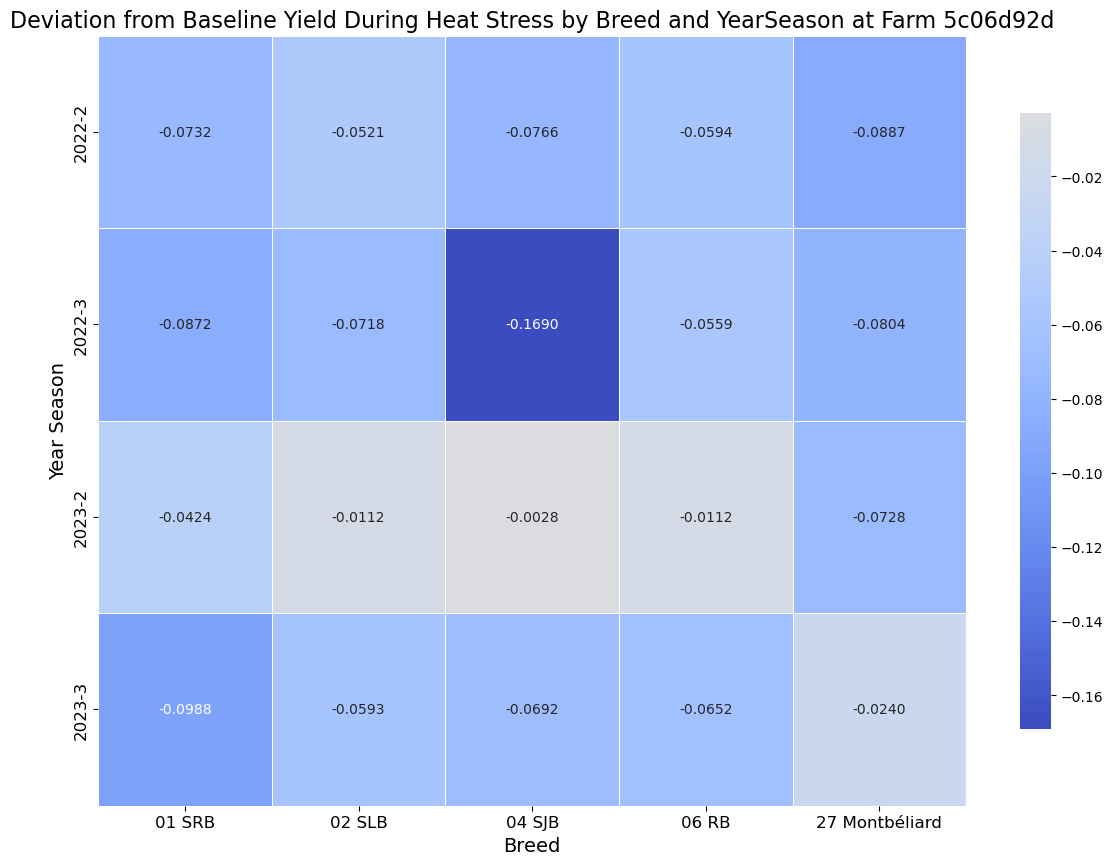

In [9]:
# Pivot data for heatmap
heatmap_data = results_df.pivot_table(index='YearSeason', columns='BreedName', values='Deviation from Baseline HeatStress=1')

plt.figure(figsize=(14, 10))
sns.heatmap(heatmap_data, annot=True, cmap="coolwarm", center=0, fmt=".4f", linewidths=.5, cbar_kws={"shrink": .8})
plt.title(f'Deviation from Baseline Yield During Heat Stress by Breed and YearSeason at Farm {farm}', fontsize=16)
plt.xlabel('Breed', fontsize=14)
plt.ylabel('Year Season', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

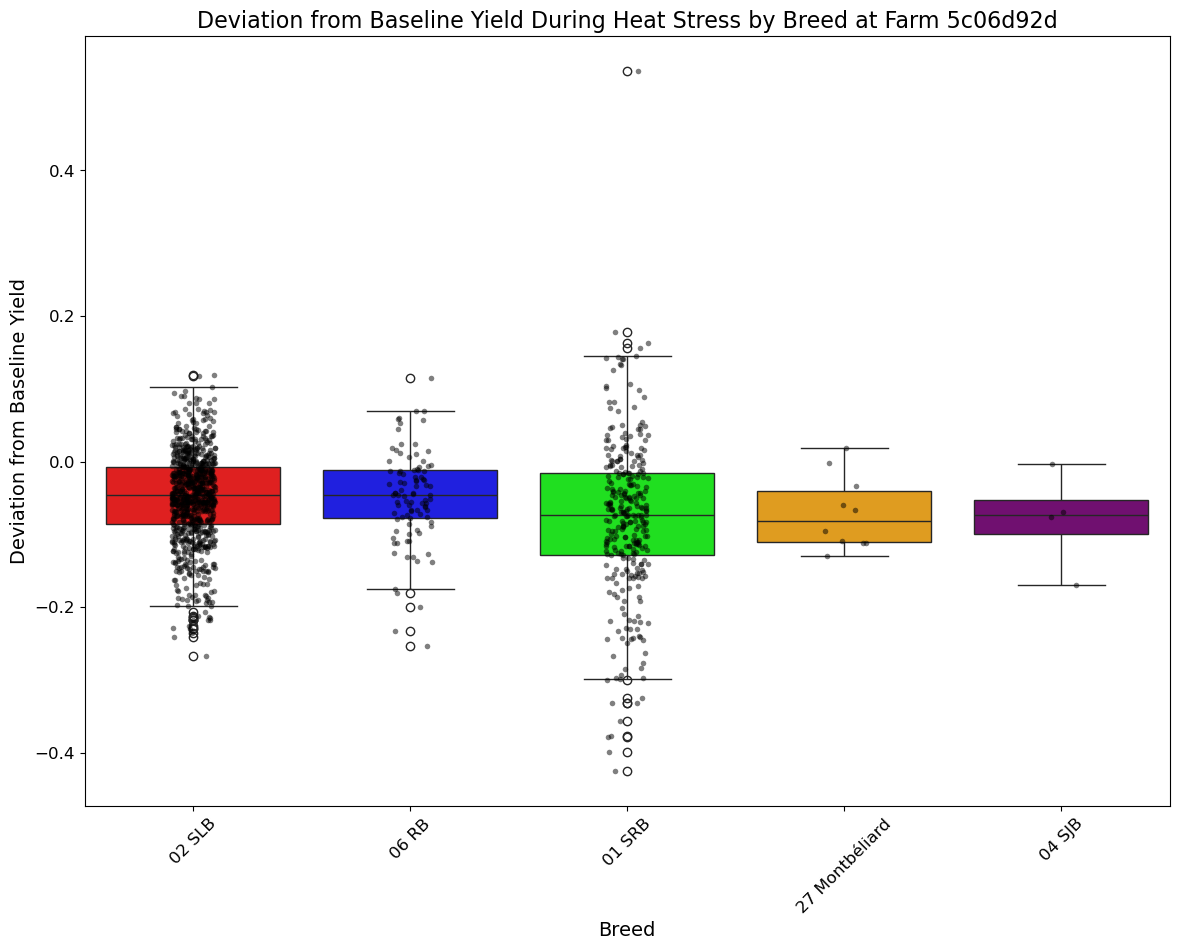

In [10]:
# Define a custom color palette with bright colors
custom_palette = ['#FF0000', '#0000FF', '#00FF00', '#FFA500', '#800080']  # Bright red, Bright blue, Bright green, Bright orange, Bright purple

plt.figure(figsize=(14, 10))
sns.boxplot(x='BreedName', y='Deviation from Baseline HeatStress=1', data=results_df, hue='BreedName', palette=custom_palette, dodge=False)
sns.stripplot(x='BreedName', y='Deviation from Baseline HeatStress=1', data=results_df, color='black', size=4, jitter=True, alpha=0.5, dodge=False)
plt.title(f'Deviation from Baseline Yield During Heat Stress by Breed at Farm {farm}', fontsize=16)
plt.xlabel('Breed', fontsize=14)
plt.ylabel('Deviation from Baseline Yield', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend([],[], frameon=False)  # Remove the legend
plt.show()

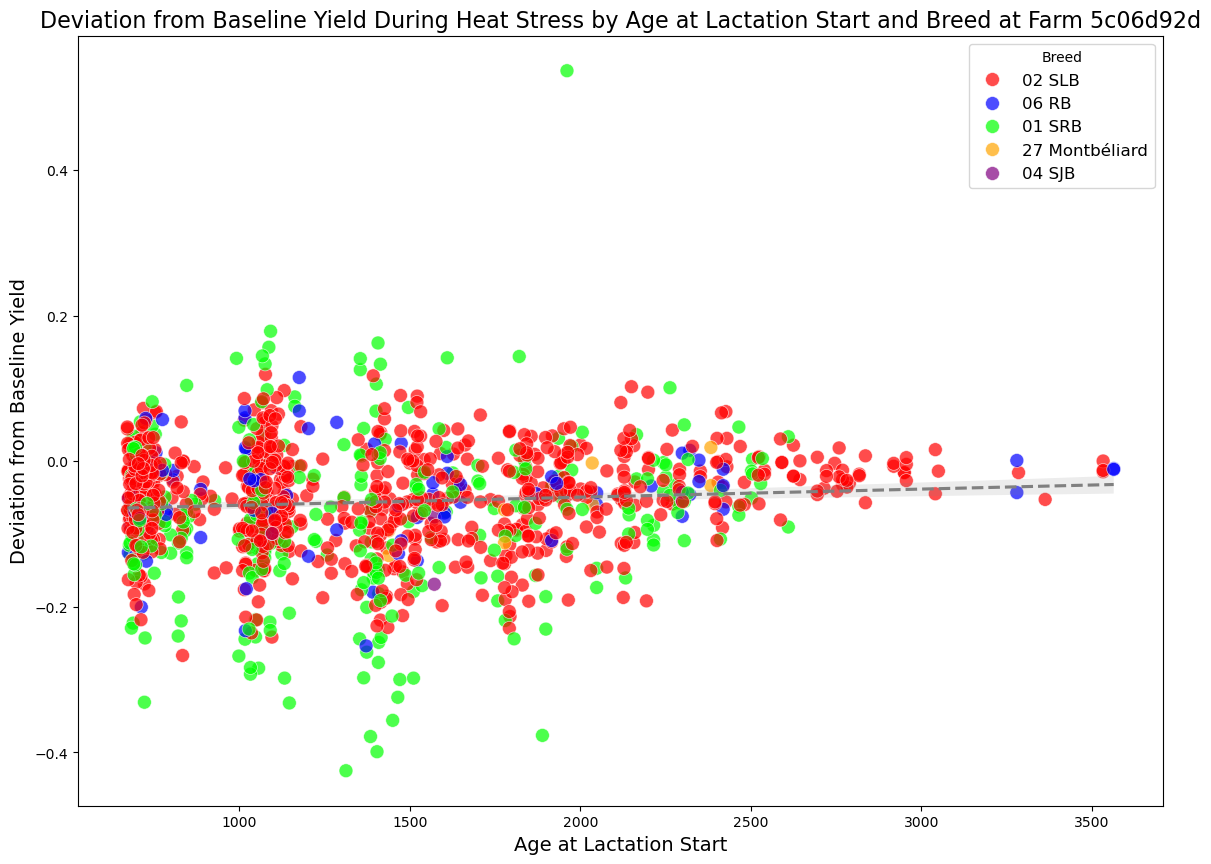

In [11]:
plt.figure(figsize=(14, 10))
sns.scatterplot(x='AgeAtLactationStart', y='Deviation from Baseline HeatStress=1', hue='BreedName', data=results_df, palette=custom_palette, s=100, alpha=0.7, edgecolor='w', linewidth=0.5)
sns.regplot(x='AgeAtLactationStart', y='Deviation from Baseline HeatStress=1', data=results_df, scatter=False, color='gray', line_kws={"linestyle":"--"})
plt.title(f'Deviation from Baseline Yield During Heat Stress by Age at Lactation Start and Breed at Farm {farm}', fontsize=16)
plt.xlabel('Age at Lactation Start', fontsize=14)
plt.ylabel('Deviation from Baseline Yield', fontsize=14)
plt.legend(title='Breed', fontsize=12)
plt.show()

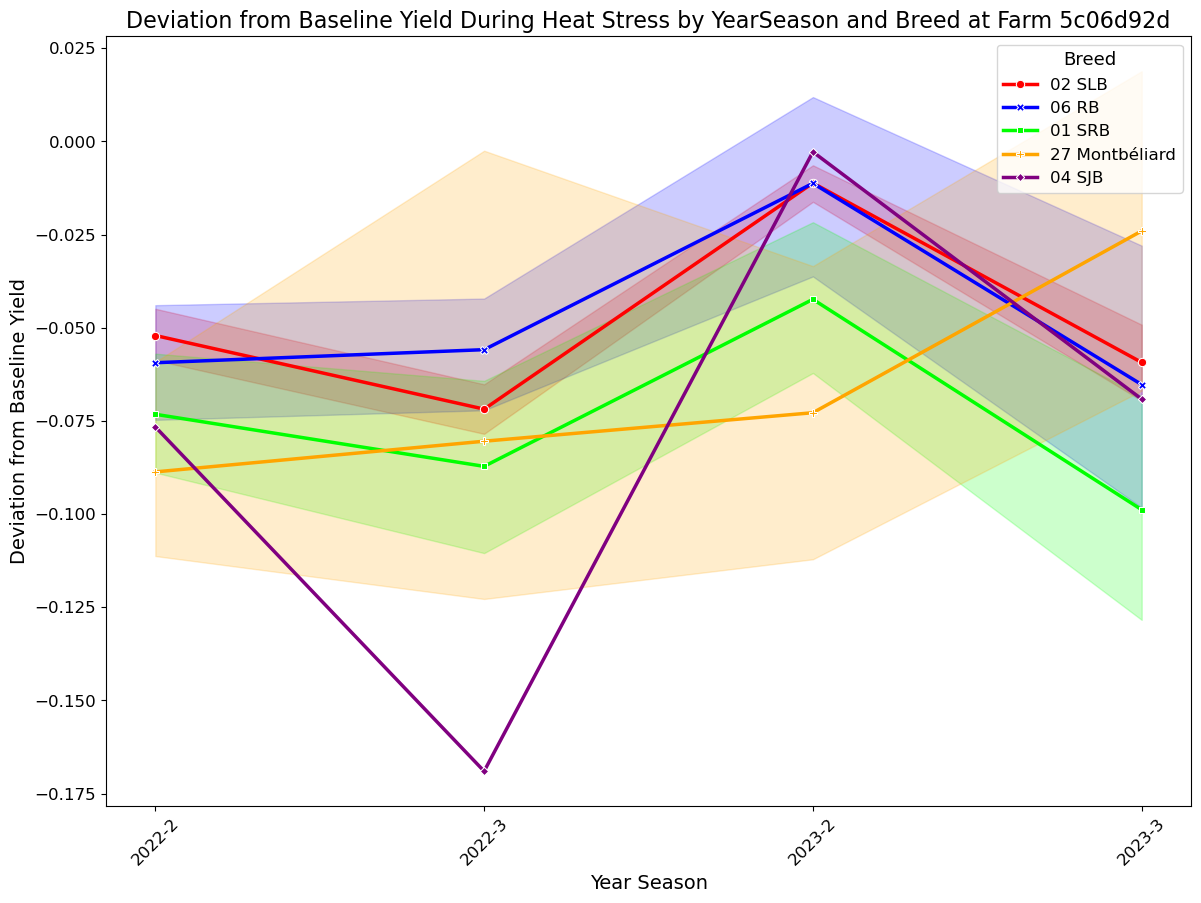

In [12]:
plt.figure(figsize=(14, 10))
sns.lineplot(x='YearSeason', y='Deviation from Baseline HeatStress=1', hue='BreedName', data=results_df, marker='o', palette=custom_palette, linewidth=2.5, style='BreedName', markers=True, dashes=False)
plt.title(f'Deviation from Baseline Yield During Heat Stress by YearSeason and Breed at Farm {farm}', fontsize=16)
plt.xlabel('Year Season', fontsize=14)
plt.ylabel('Deviation from Baseline Yield', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Breed', fontsize=12, title_fontsize='13')
plt.show()

## Farm 752efd72

In [13]:
# Select the farm
farm = '752efd72'
daily_farm_data = milk_data[milk_data['FarmName_Pseudo'] == farm].copy()

# Ensure the feature 'MeanTemperature' is float type
daily_farm_data['MeanTemperature'] = daily_farm_data['MeanTemperature'].astype(float)

# Scale features
scaler = StandardScaler()
daily_farm_data[['MeanTemperature', 'Age']] = scaler.fit_transform(daily_farm_data[['MeanTemperature', 'Age']])

# Function to fit model and calculate yield change
def fit_model_and_calculate_yield_change(data, feature, additional_features):
    yield_changes = []
    grouped_data = data.groupby(['YearSeason', 'SE_Number'])
    
    for (year_season, cow), group in grouped_data:
        cow_data = group

        # Prepare features
        X = cow_data[[feature] + additional_features]
        y = cow_data['NormalizedDailyYield']

        # Calculate prior mean and variance
        cow_mean = y.mean()
        cow_variance = y.var() if y.var() > 1e-6 else 1e-6
        beta = 1 / cow_variance
        prior_mean_value = X.mean(axis=0)

        # Define priors
        prior_mean = np.append([cow_mean], prior_mean_value.values).reshape(-1, 1)
        prior_cov = np.eye(len(prior_mean)) * 0.01

        # Fit model
        model = BayesianLinearRegression(
            dataframe=cow_data,
            subject_name=cow,
            selected_features=[feature] + additional_features,
            target='NormalizedDailyYield',
            subject_type='cow',
            prior_mean=prior_mean,
            prior_cov=prior_cov,
            beta=beta
        )
        result = model.fit_model()

        # Store results
        yield_changes.append({
            'YearSeason': year_season,
            'SE_Number': cow,
            'Yield HeatStress': result['Off-set']['mu']
        })

    return pd.DataFrame(yield_changes)

# Define features
selected_feature = 'MeanTemperature'
additional_features = list(encoded_breeds.columns) + ['Age']

# Separate data for HeatStress=1 and HeatStress=0 conditions
data_heatstress_1 = daily_farm_data[daily_farm_data['HeatStress'] == 1]
data_heatstress_0 = daily_farm_data[daily_farm_data['HeatStress'] == 0]

# Fit models and calculate yield changes
yield_changes_heatstress_1 = fit_model_and_calculate_yield_change(data_heatstress_1, selected_feature, additional_features)
yield_changes_heatstress_0 = fit_model_and_calculate_yield_change(data_heatstress_0, selected_feature, additional_features)

# Merge results with breed data and calculate deviations
results_df = yield_changes_heatstress_1.merge(
    yield_changes_heatstress_0, on=['YearSeason', 'SE_Number'], suffixes=('=1', '=0')
)

# Merge age and breed data back to results_df using the AgeAtLactationStart column
# Ensure unique combinations of SE_Number and YearSeason in the daily_farm_data for merging
unique_age_breed_data = daily_farm_data[['SE_Number', 'YearSeason', 'AgeAtLactationStart', 'BreedName']].drop_duplicates(subset=['SE_Number', 'YearSeason'])

results_df = results_df.merge(
    unique_age_breed_data, on=['SE_Number', 'YearSeason'], how='left'
)

# Calculate the correct deviation from baseline
# baseline_yield_change = daily_farm_data['NormalizedDailyYield'].mean() + data_heatstress_1['FarmHeatStressMilkProduction'].mean()
baseline_yield_change = daily_farm_data['NormalizedDailyYield'].mean()
results_df['Deviation from Baseline HeatStress=1'] = results_df['Yield HeatStress=1'] - baseline_yield_change  # Corrected calculation

# Reorder columns to make SE_Number the first column
results_df = results_df[['SE_Number', 'YearSeason', 'AgeAtLactationStart', 'BreedName', 'Yield HeatStress=1', 'Yield HeatStress=0', 'Deviation from Baseline HeatStress=1']]
results_df

,SE_Number,YearSeason,AgeAtLactationStart,BreedName,Yield HeatStress=1,Yield HeatStress=0,Deviation from Baseline HeatStress=1
0,SE-752efd72-0001,2022-2,2022,Unknown Breed,1.039910,0.991956,0.036715
1,SE-752efd72-0002,2022-2,1966,02 SLB,1.041874,0.948266,0.038679
2,SE-752efd72-0008,2022-2,1896,02 SLB,1.027957,0.934535,0.024762
3,SE-752efd72-0010,2022-2,1953,02 SLB,1.045846,1.028386,0.042652
4,SE-752efd72-0011,2022-2,1966,02 SLB,1.011888,1.007692,0.008694
...,...,...,...,...,...,...,...
949,SE-752efd72-2709,2023-3,2552,02 SLB,0.990920,1.014412,-0.012275
950,SE-752efd72-2777,2023-3,2232,02 SLB,1.021318,0.831425,0.018123
951,SE-752efd72-2780,2023-3,2536,02 SLB,0.979145,0.938907,-0.024050
952,SE-752efd72-2784,2023-3,2210,02 SLB,1.032875,1.152773,0.029680


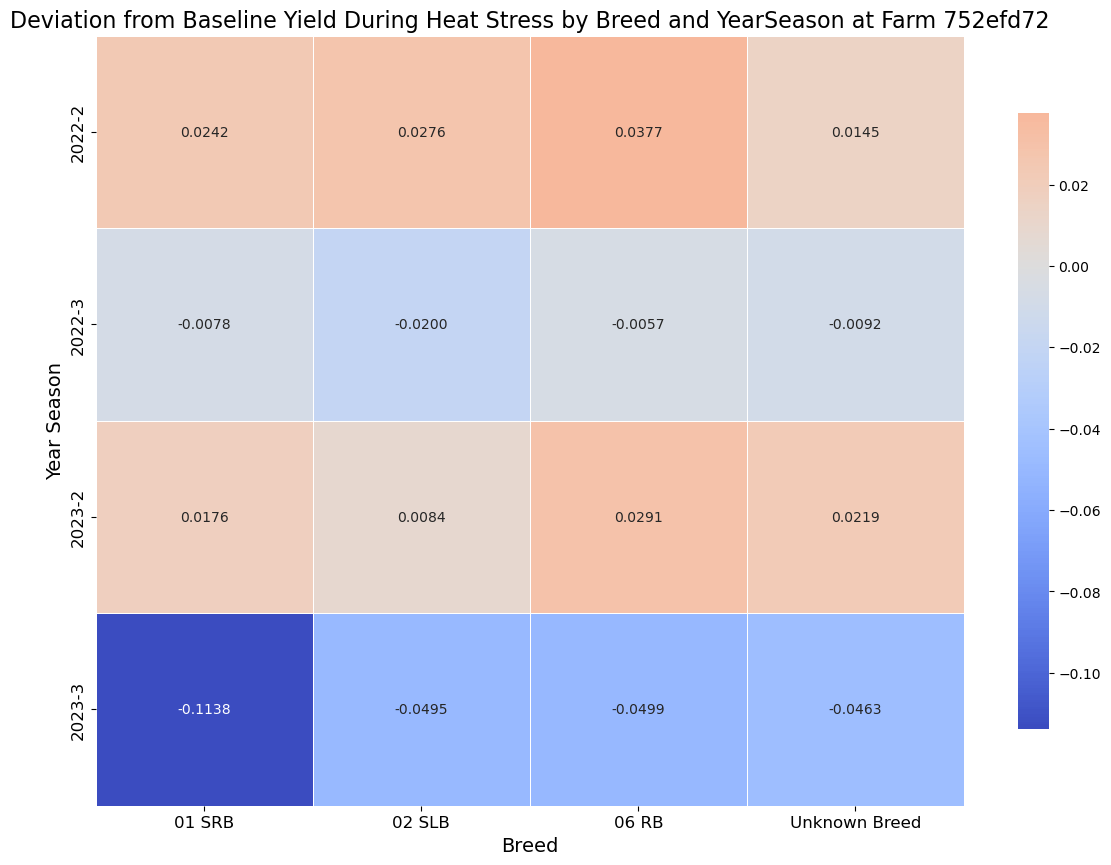

In [14]:
# Pivot data for heatmap
heatmap_data = results_df.pivot_table(index='YearSeason', columns='BreedName', values='Deviation from Baseline HeatStress=1')

plt.figure(figsize=(14, 10))
sns.heatmap(heatmap_data, annot=True, cmap="coolwarm", center=0, fmt=".4f", linewidths=.5, cbar_kws={"shrink": .8})
plt.title(f'Deviation from Baseline Yield During Heat Stress by Breed and YearSeason at Farm {farm}', fontsize=16)
plt.xlabel('Breed', fontsize=14)
plt.ylabel('Year Season', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

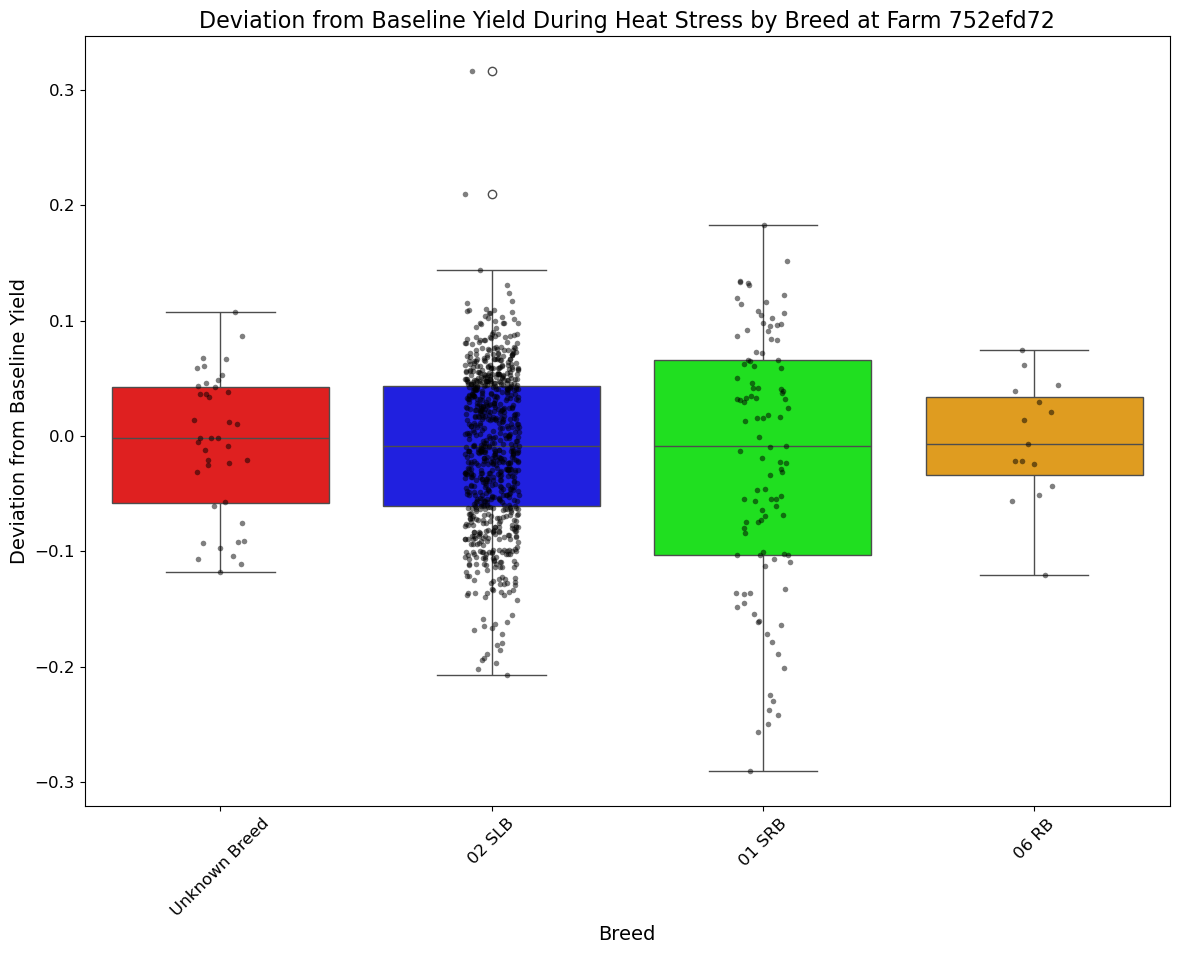

In [15]:
# Define a custom color palette with bright colors
custom_palette = ['#FF0000', '#0000FF', '#00FF00', '#FFA500']  # Bright red, Bright blue, Bright green, Bright orange

plt.figure(figsize=(14, 10))
sns.boxplot(x='BreedName', y='Deviation from Baseline HeatStress=1', data=results_df, hue='BreedName', palette=custom_palette, dodge=False)
sns.stripplot(x='BreedName', y='Deviation from Baseline HeatStress=1', data=results_df, color='black', size=4, jitter=True, alpha=0.5, dodge=False)
plt.title(f'Deviation from Baseline Yield During Heat Stress by Breed at Farm {farm}', fontsize=16)
plt.xlabel('Breed', fontsize=14)
plt.ylabel('Deviation from Baseline Yield', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend([],[], frameon=False)  # Remove the legend
plt.show()

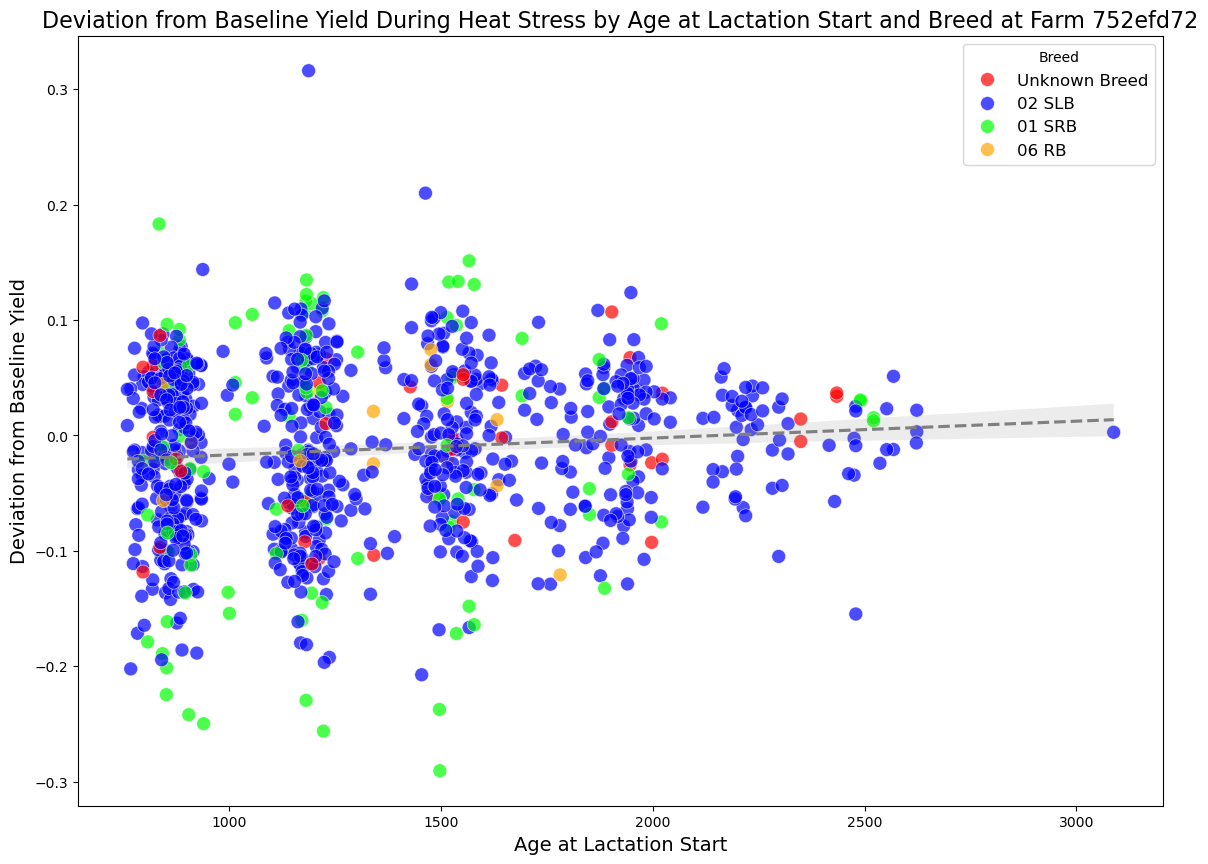

In [16]:
plt.figure(figsize=(14, 10))
sns.scatterplot(x='AgeAtLactationStart', y='Deviation from Baseline HeatStress=1', hue='BreedName', data=results_df, palette=custom_palette, s=100, alpha=0.7, edgecolor='w', linewidth=0.5)
sns.regplot(x='AgeAtLactationStart', y='Deviation from Baseline HeatStress=1', data=results_df, scatter=False, color='gray', line_kws={"linestyle":"--"})
plt.title(f'Deviation from Baseline Yield During Heat Stress by Age at Lactation Start and Breed at Farm {farm}', fontsize=16)
plt.xlabel('Age at Lactation Start', fontsize=14)
plt.ylabel('Deviation from Baseline Yield', fontsize=14)
plt.legend(title='Breed', fontsize=12)
plt.show()

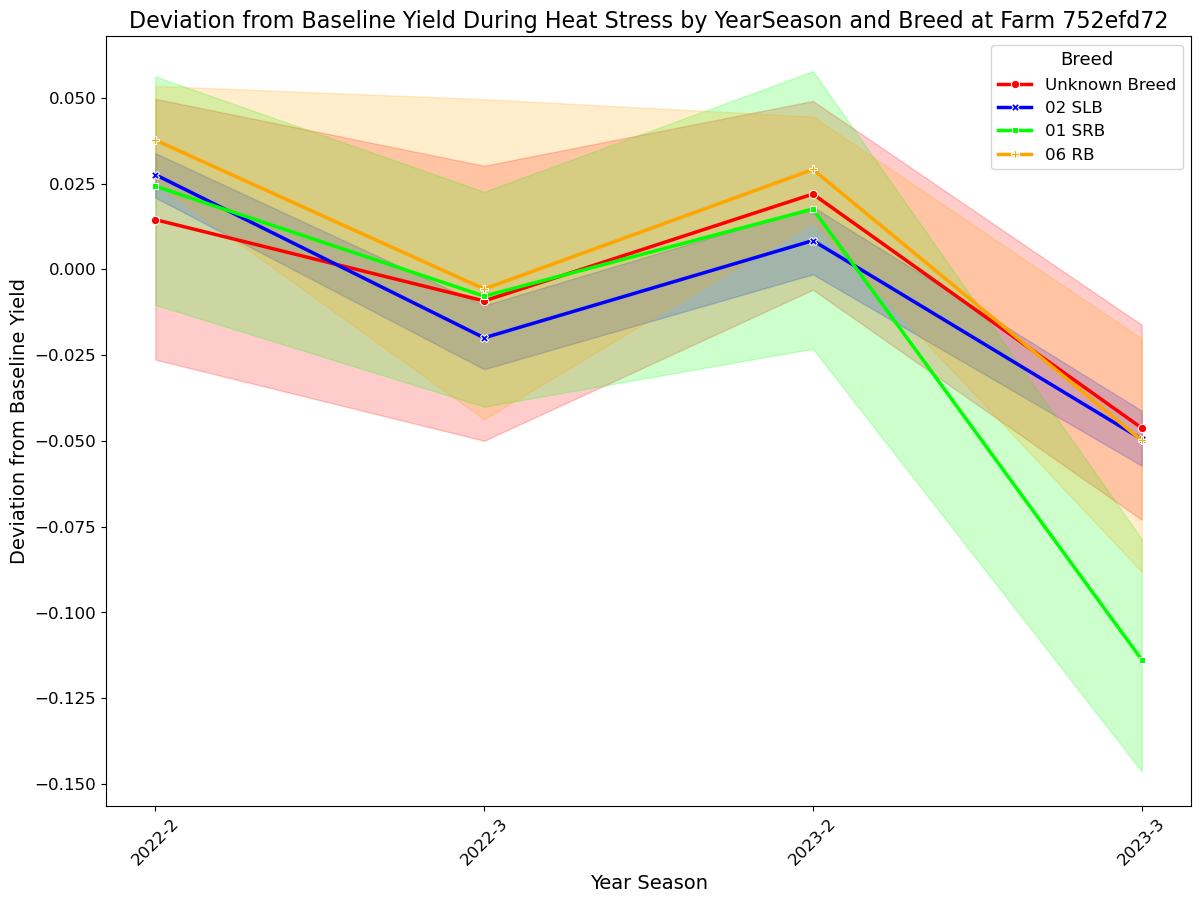

In [17]:
plt.figure(figsize=(14, 10))
sns.lineplot(x='YearSeason', y='Deviation from Baseline HeatStress=1', hue='BreedName', data=results_df, marker='o', palette=custom_palette, linewidth=2.5, style='BreedName', markers=True, dashes=False)
plt.title(f'Deviation from Baseline Yield During Heat Stress by YearSeason and Breed at Farm {farm}', fontsize=16)
plt.xlabel('Year Season', fontsize=14)
plt.ylabel('Deviation from Baseline Yield', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Breed', fontsize=12, title_fontsize='13')
plt.show()

## Farm f454e660

In [18]:
# Select the farm
farm = 'f454e660'
daily_farm_data = milk_data[milk_data['FarmName_Pseudo'] == farm].copy()

# Ensure the feature 'MeanTemperature' is float type
daily_farm_data['MeanTemperature'] = daily_farm_data['MeanTemperature'].astype(float)

# Scale features
scaler = StandardScaler()
daily_farm_data[['MeanTemperature', 'Age']] = scaler.fit_transform(daily_farm_data[['MeanTemperature', 'Age']])

# Function to fit model and calculate yield change
def fit_model_and_calculate_yield_change(data, feature, additional_features):
    yield_changes = []
    grouped_data = data.groupby(['YearSeason', 'SE_Number'])
    
    for (year_season, cow), group in grouped_data:
        cow_data = group

        # Prepare features
        X = cow_data[[feature] + additional_features]
        y = cow_data['NormalizedDailyYield']

        # Calculate prior mean and variance
        cow_mean = y.mean()
        cow_variance = y.var() if y.var() > 1e-6 else 1e-6
        beta = 1 / cow_variance
        prior_mean_value = X.mean(axis=0)

        # Define priors
        prior_mean = np.append([cow_mean], prior_mean_value.values).reshape(-1, 1)
        prior_cov = np.eye(len(prior_mean)) * 0.01

        # Fit model
        model = BayesianLinearRegression(
            dataframe=cow_data,
            subject_name=cow,
            selected_features=[feature] + additional_features,
            target='NormalizedDailyYield',
            subject_type='cow',
            prior_mean=prior_mean,
            prior_cov=prior_cov,
            beta=beta
        )
        result = model.fit_model()

        # Store results
        yield_changes.append({
            'YearSeason': year_season,
            'SE_Number': cow,
            'Yield HeatStress': result['Off-set']['mu']
        })

    return pd.DataFrame(yield_changes)

# Define features
selected_feature = 'MeanTemperature'
additional_features = list(encoded_breeds.columns) + ['Age']

# Separate data for HeatStress=1 and HeatStress=0 conditions
data_heatstress_1 = daily_farm_data[daily_farm_data['HeatStress'] == 1]
data_heatstress_0 = daily_farm_data[daily_farm_data['HeatStress'] == 0]

# Fit models and calculate yield changes
yield_changes_heatstress_1 = fit_model_and_calculate_yield_change(data_heatstress_1, selected_feature, additional_features)
yield_changes_heatstress_0 = fit_model_and_calculate_yield_change(data_heatstress_0, selected_feature, additional_features)

# Merge results with breed data and calculate deviations
results_df = yield_changes_heatstress_1.merge(
    yield_changes_heatstress_0, on=['YearSeason', 'SE_Number'], suffixes=('=1', '=0')
)

# Merge age and breed data back to results_df using the AgeAtLactationStart column
# Ensure unique combinations of SE_Number and YearSeason in the daily_farm_data for merging
unique_age_breed_data = daily_farm_data[['SE_Number', 'YearSeason', 'AgeAtLactationStart', 'BreedName']].drop_duplicates(subset=['SE_Number', 'YearSeason'])

results_df = results_df.merge(
    unique_age_breed_data, on=['SE_Number', 'YearSeason'], how='left'
)

# Calculate the correct deviation from baseline
# baseline_yield_change = daily_farm_data['NormalizedDailyYield'].mean() + data_heatstress_1['FarmHeatStressMilkProduction'].mean()
baseline_yield_change = daily_farm_data['NormalizedDailyYield'].mean()
results_df['Deviation from Baseline HeatStress=1'] = results_df['Yield HeatStress=1'] - baseline_yield_change  # Corrected calculation

# Reorder columns to make SE_Number the first column
results_df = results_df[['SE_Number', 'YearSeason', 'AgeAtLactationStart', 'BreedName', 'Yield HeatStress=1', 'Yield HeatStress=0', 'Deviation from Baseline HeatStress=1']]
results_df

,SE_Number,YearSeason,AgeAtLactationStart,BreedName,Yield HeatStress=1,Yield HeatStress=0,Deviation from Baseline HeatStress=1
0,SE-a2bab923-0680,2022-2,4202,04 SJB,0.997666,0.977004,-0.003161
1,SE-f454e660-0139,2022-2,2797,04 SJB,1.085071,0.987972,0.084244
2,SE-f454e660-0157,2022-2,2736,02 SLB,0.989371,1.018474,-0.011456
3,SE-f454e660-0235,2022-2,2398,02 SLB,0.939188,0.971909,-0.061639
4,SE-f454e660-0277,2022-2,2236,99 Korsning/obestämbar ras,0.909606,0.972255,-0.091221
...,...,...,...,...,...,...,...
797,SE-f454e660-0799,2023-4,651,02 SLB,1.023148,0.975595,0.022321
798,SE-f454e660-0800,2023-4,766,01 SRB,1.041526,1.007803,0.040699
799,SE-f454e660-0803,2023-4,701,99 Korsning/obestämbar ras,0.924247,0.963958,-0.076580
800,SE-f454e660-0804,2023-4,662,02 SLB,1.007216,0.989884,0.006389


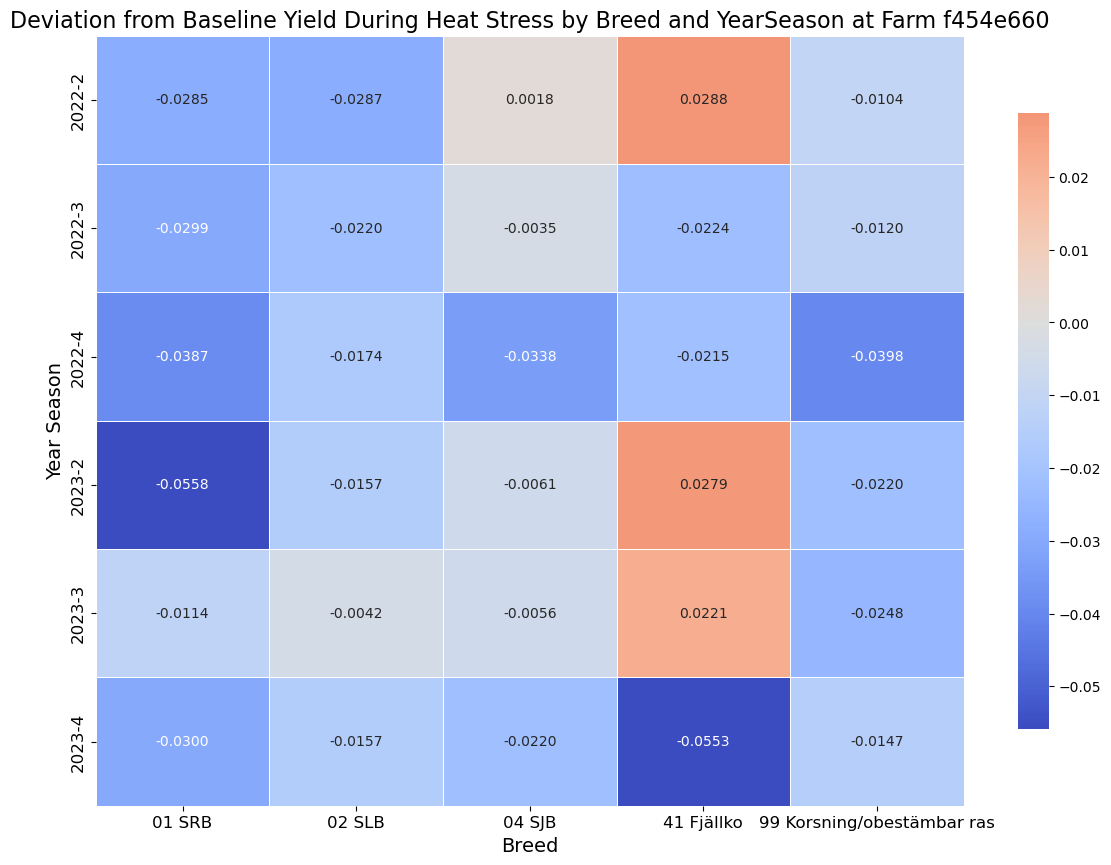

In [19]:
# Pivot data for heatmap
heatmap_data = results_df.pivot_table(index='YearSeason', columns='BreedName', values='Deviation from Baseline HeatStress=1')

plt.figure(figsize=(14, 10))
sns.heatmap(heatmap_data, annot=True, cmap="coolwarm", center=0, fmt=".4f", linewidths=.5, cbar_kws={"shrink": .8})
plt.title(f'Deviation from Baseline Yield During Heat Stress by Breed and YearSeason at Farm {farm}', fontsize=16)
plt.xlabel('Breed', fontsize=14)
plt.ylabel('Year Season', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

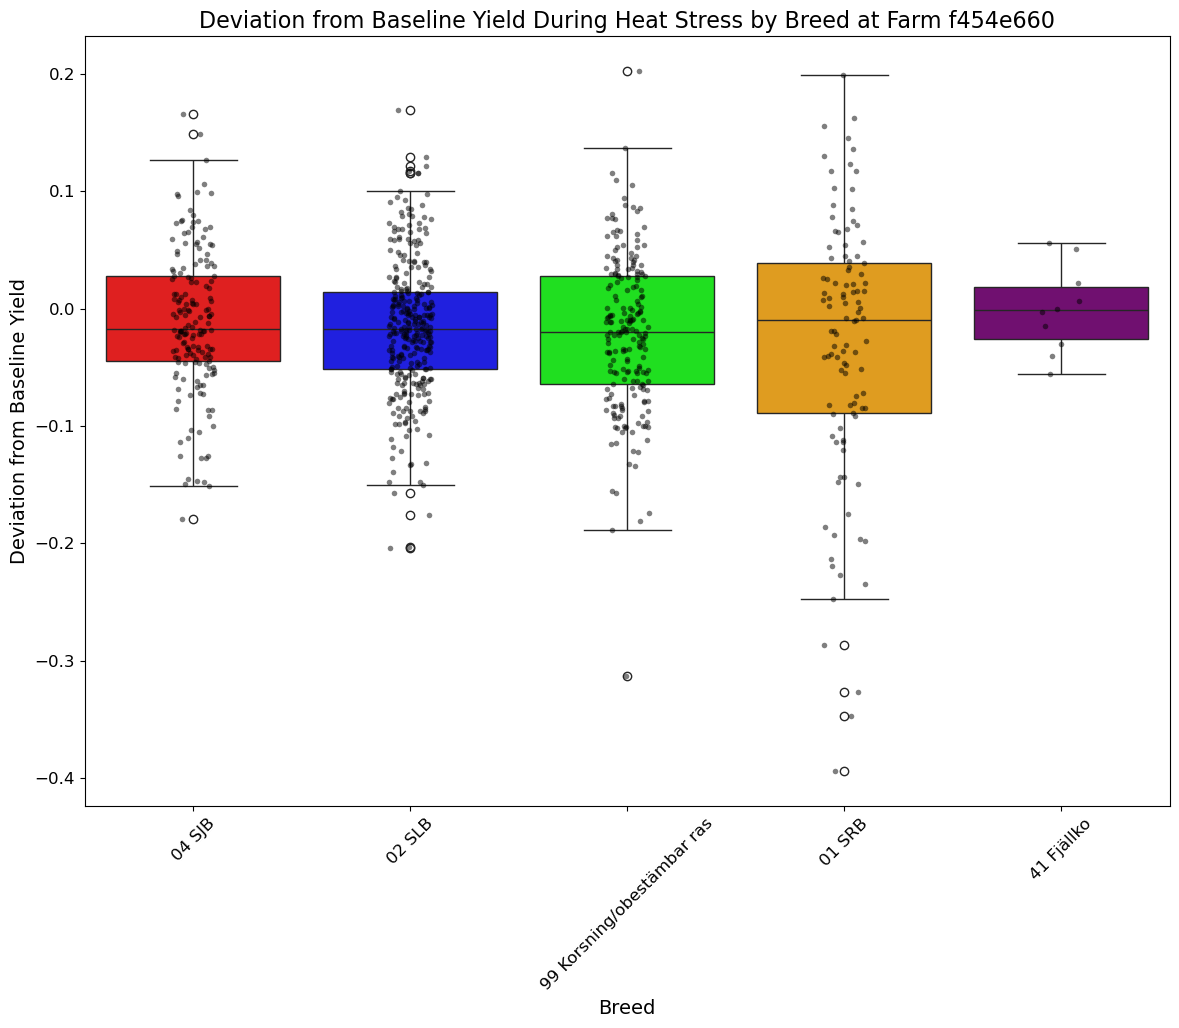

In [20]:
# Define a custom color palette with bright colors
custom_palette = ['#FF0000', '#0000FF', '#00FF00', '#FFA500', '#800080']  # Bright red, Bright blue, Bright green, Bright orange, Bright purple

plt.figure(figsize=(14, 10))
sns.boxplot(x='BreedName', y='Deviation from Baseline HeatStress=1', data=results_df, hue='BreedName', palette=custom_palette, dodge=False)
sns.stripplot(x='BreedName', y='Deviation from Baseline HeatStress=1', data=results_df, color='black', size=4, jitter=True, alpha=0.5, dodge=False)
plt.title(f'Deviation from Baseline Yield During Heat Stress by Breed at Farm {farm}', fontsize=16)
plt.xlabel('Breed', fontsize=14)
plt.ylabel('Deviation from Baseline Yield', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend([],[], frameon=False)  # Remove the legend
plt.show()

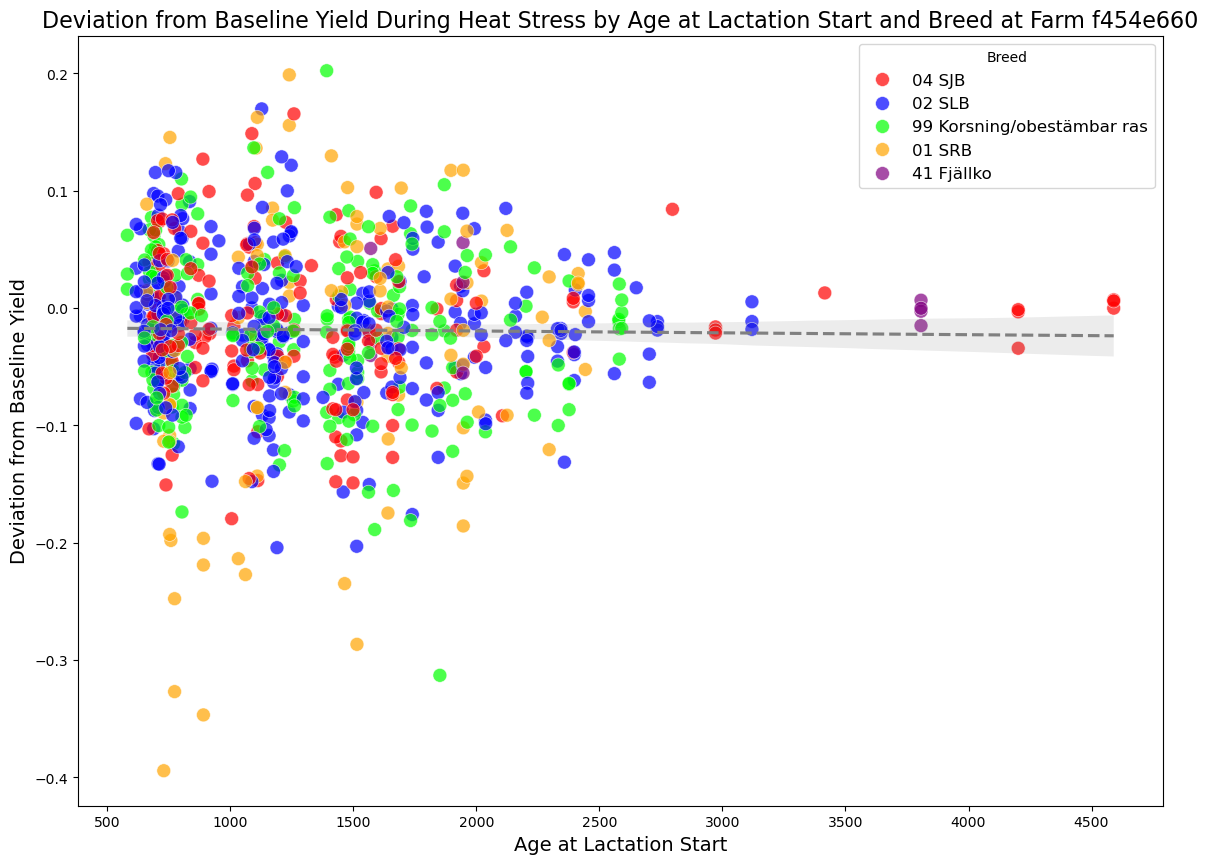

In [21]:
plt.figure(figsize=(14, 10))
sns.scatterplot(x='AgeAtLactationStart', y='Deviation from Baseline HeatStress=1', hue='BreedName', data=results_df, palette=custom_palette, s=100, alpha=0.7, edgecolor='w', linewidth=0.5)
sns.regplot(x='AgeAtLactationStart', y='Deviation from Baseline HeatStress=1', data=results_df, scatter=False, color='gray', line_kws={"linestyle":"--"})
plt.title(f'Deviation from Baseline Yield During Heat Stress by Age at Lactation Start and Breed at Farm {farm}', fontsize=16)
plt.xlabel('Age at Lactation Start', fontsize=14)
plt.ylabel('Deviation from Baseline Yield', fontsize=14)
plt.legend(title='Breed', fontsize=12)
plt.show()

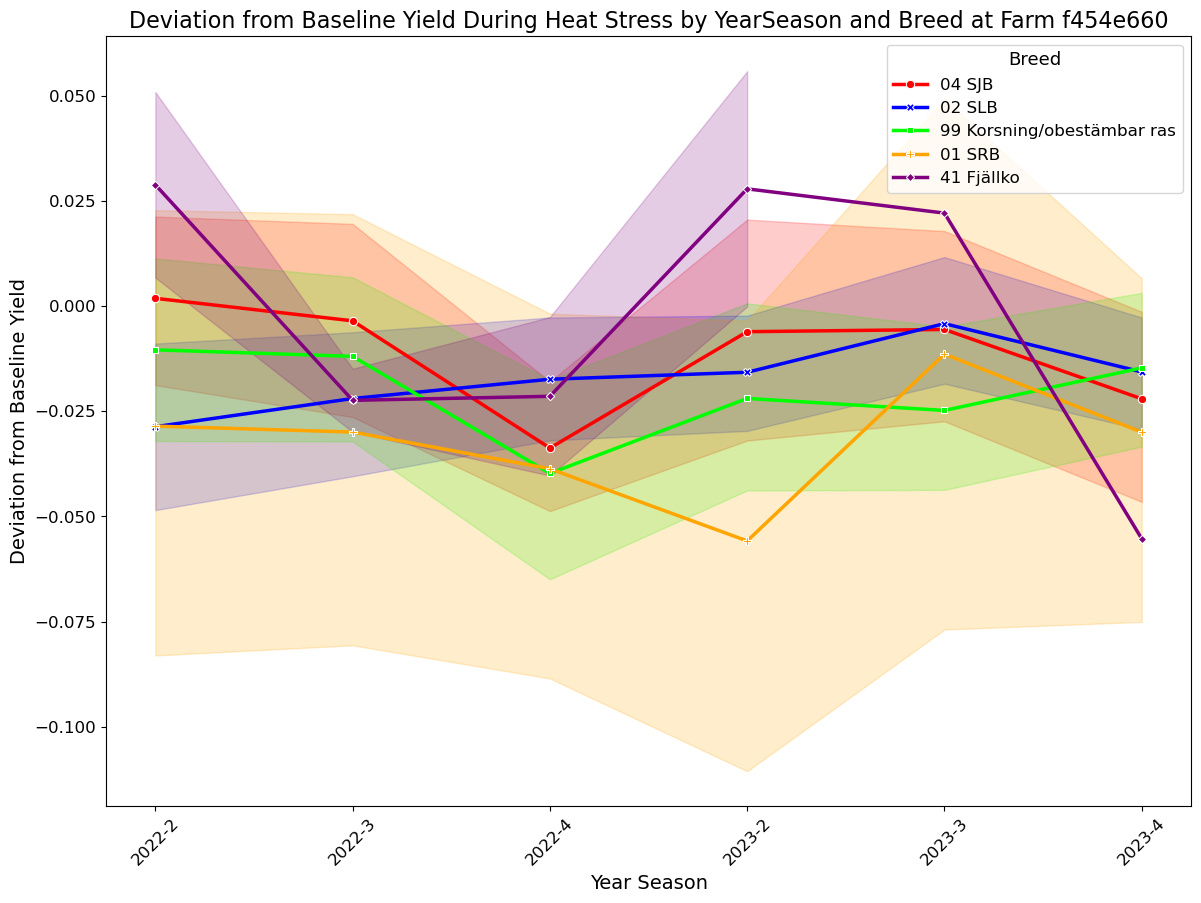

In [22]:
plt.figure(figsize=(14, 10))
sns.lineplot(x='YearSeason', y='Deviation from Baseline HeatStress=1', hue='BreedName', data=results_df, marker='o', palette=custom_palette, linewidth=2.5, style='BreedName', markers=True, dashes=False)
plt.title(f'Deviation from Baseline Yield During Heat Stress by YearSeason and Breed at Farm {farm}', fontsize=16)
plt.xlabel('Year Season', fontsize=14)
plt.ylabel('Deviation from Baseline Yield', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Breed', fontsize=12, title_fontsize='13')
plt.show()